## Importing the Libraries

In [ ]:
import gc
gc.enable

import os
import pandas as pd

pd.options.mode.chained_assignment = None
import numpy as np
import re
import nltk
nltk.download('stopwords')
import spacy
import string
import seaborn as sns
from nltk.stem.snowball import SnowballStemmer
# from matplotlib import pyplot as plt
# %matplotlib inline 

sns.set(rc={'figure.figsize':(15, 16)})

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Loading the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [ ]:
project_path = r"/content/drive/MyDrive/"
os.chdir(project_path)
os.getcwd()

'/content/drive/MyDrive'

In [ ]:
data_original = pd.read_csv('blogtext.csv', index_col=False)
data_original.shape

(681284, 7)

In [ ]:
# droping id and date columns
data_original.drop(labels=['id','date'], axis=1,inplace=True)

# the next step is to randomize the rows of the data
data_original = data_original.sample(frac=1).reset_index(drop=True)

## Exploratory Analysis

In [ ]:
data_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681284 entries, 0 to 681283
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   gender  681284 non-null  object
 1   age     681284 non-null  int64 
 2   topic   681284 non-null  object
 3   sign    681284 non-null  object
 4   text    681284 non-null  object
dtypes: int64(1), object(4)
memory usage: 26.0+ MB


In [ ]:
data_original.sample(5)

,gender,age,topic,sign,text
76369,male,37,indUnk,Leo,First of all... if you're the guy with ...
456865,male,23,indUnk,Sagittarius,Sigma Corporation is pleased to ann...
237749,male,15,indUnk,Scorpio,todae must sae lots of sorry.... first...
101803,male,35,Technology,Aries,had a great time at the dinner part...
615298,male,39,Technology,Scorpio,Logged into XBox Live (XBL) and saw tha...


In [ ]:
data_original.gender.value_counts()

male      345193
female    336091
Name: gender, dtype: int64

In [ ]:
data_original.age.value_counts()

17    80859
24    80071
23    72889
16    72708
25    67051
26    55312
27    46124
15    41767
14    27400
34    21347
33    17584
35    17462
36    14229
13    13133
37     9317
38     7545
39     5556
40     5016
45     4482
43     4230
41     3738
48     3572
42     2908
46     2733
47     2207
44     2044
Name: age, dtype: int64

In [ ]:
data_original.topic.value_counts()

indUnk                     251015
Student                    153903
Technology                  42055
Arts                        32449
Education                   29633
Communications-Media        20140
Internet                    16006
Non-Profit                  14700
Engineering                 11653
Law                          9040
Publishing                   7753
Science                      7269
Government                   6907
Consulting                   5862
Religion                     5235
Fashion                      4851
Marketing                    4769
Advertising                  4676
BusinessServices             4500
Banking                      4049
Chemicals                    3928
Telecommunications           3891
Accounting                   3832
Military                     3128
Museums-Libraries            3096
Sports-Recreation            3038
HumanResources               3010
RealEstate                   2870
Transportation               2326
Manufacturing 

In [ ]:
data_original.sign.value_counts()

Cancer         65048
Aries          64979
Taurus         62561
Libra          62363
Virgo          60399
Scorpio        57161
Pisces         54053
Leo            53811
Gemini         51985
Sagittarius    50036
Aquarius       49687
Capricorn      49201
Name: sign, dtype: int64

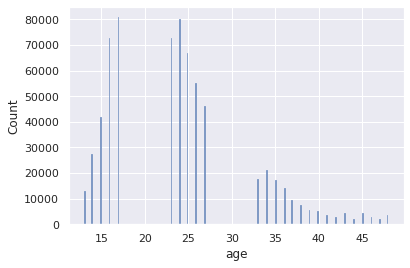

In [ ]:
sns.histplot(data_original.age)

Except for the column topics most of the data seems balanced

## Taking a sample of the data instead of the total data will help in reducing the data size and hence the computation requirement

In [ ]:
def stratified_sample(df, strata, size=None, seed=None, keep_index= True):
    population = len(df)
    size = __smpl_size(population, size)
    tmp = df[strata]
    tmp['size'] = 1
    tmp_grpd = tmp.groupby(strata).count().reset_index()
    tmp_grpd['samp_size'] = round(size/population * tmp_grpd['size']).astype(int)

    # controlling variable to create the dataframe or append to it
    first = True 
    for i in range(len(tmp_grpd)):
        # query generator for each iteration
        qry=''
        for s in range(len(strata)):
            stratum = strata[s]
            value = tmp_grpd.iloc[i][stratum]
            n = tmp_grpd.iloc[i]['samp_size']

            if type(value) == str:
                value = "'" + str(value) + "'"
            
            if s != len(strata)-1:
                qry = qry + stratum + ' == ' + str(value) +' & '
            else:
                qry = qry + stratum + ' == ' + str(value)
        
        # final dataframe
        if first:
            stratified_df = df.query(qry).sample(n=n, random_state=seed).reset_index(drop=(not keep_index))
            first = False
        else:
            tmp_df = df.query(qry).sample(n=n, random_state=seed).reset_index(drop=(not keep_index))
            stratified_df = stratified_df.append(tmp_df, ignore_index=True)
    
    return stratified_df



def stratified_sample_report(df, strata, size=None):
    population = len(df)
    size = __smpl_size(population, size)
    tmp = df[strata]
    tmp['size'] = 1
    tmp_grpd = tmp.groupby(strata).count().reset_index()
    tmp_grpd['samp_size'] = round(size/population * tmp_grpd['size']).astype(int)
    return tmp_grpd


def __smpl_size(population, size):
    if size is None:
        cochran_n = round(((1.96)**2 * 0.5 * 0.5)/ 0.02**2)
        n = round(cochran_n/(1+((cochran_n -1) /population)))
    elif size >= 0 and size < 1:
        n = round(population * size)
    elif size < 0:
        raise ValueError('Parameter "size" must be an integer or a proportion between 0 and 0.99.')
    elif size >= 1:
        n = size
    return n

In [ ]:
new_data = stratified_sample(data_original, ['sign', 'gender', 'topic', 'age'], size=40000, seed=0, keep_index= True)

In [ ]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39842 entries, 0 to 39841
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   39842 non-null  int64 
 1   gender  39842 non-null  object
 2   age     39842 non-null  int64 
 3   topic   39842 non-null  object
 4   sign    39842 non-null  object
 5   text    39842 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.8+ MB


In [ ]:
print(data_original.gender.value_counts(1))
print(new_data.gender.value_counts(1))


male      0.50668
female    0.49332
Name: gender, dtype: float64
male      0.506476
female    0.493524
Name: gender, dtype: float64


In [ ]:
print(data_original.age.value_counts(1))
print(new_data.age.value_counts(1))

17    0.118686
24    0.117530
23    0.106988
16    0.106722
25    0.098419
26    0.081188
27    0.067702
15    0.061306
14    0.040218
34    0.031333
33    0.025810
35    0.025631
36    0.020886
13    0.019277
37    0.013676
38    0.011075
39    0.008155
40    0.007363
45    0.006579
43    0.006209
41    0.005487
48    0.005243
42    0.004268
46    0.004012
47    0.003239
44    0.003000
Name: age, dtype: float64
17    0.119020
24    0.118041
16    0.106998
23    0.106947
25    0.098238
26    0.081171
27    0.067768
15    0.061543
14    0.040159
34    0.031324
33    0.025777
35    0.025551
36    0.020757
13    0.019301
37    0.013579
38    0.010993
39    0.008082
40    0.007329
45    0.006526
43    0.006149
41    0.005396
48    0.005120
42    0.004141
46    0.003966
47    0.003238
44    0.002886
Name: age, dtype: float64


In [ ]:
print(data_original.topic.value_counts(1))
print(new_data.topic.value_counts(1))

indUnk                     0.368444
Student                    0.225901
Technology                 0.061729
Arts                       0.047629
Education                  0.043496
Communications-Media       0.029562
Internet                   0.023494
Non-Profit                 0.021577
Engineering                0.017104
Law                        0.013269
Publishing                 0.011380
Science                    0.010670
Government                 0.010138
Consulting                 0.008604
Religion                   0.007684
Fashion                    0.007120
Marketing                  0.007000
Advertising                0.006864
BusinessServices           0.006605
Banking                    0.005943
Chemicals                  0.005766
Telecommunications         0.005711
Accounting                 0.005625
Military                   0.004591
Museums-Libraries          0.004544
Sports-Recreation          0.004459
HumanResources             0.004418
RealEstate                 0

In [ ]:
print(data_original.sign.value_counts(1))
print(new_data.sign.value_counts(1))

Cancer         0.095479
Aries          0.095377
Taurus         0.091828
Libra          0.091537
Virgo          0.088655
Scorpio        0.083902
Pisces         0.079340
Leo            0.078985
Gemini         0.076304
Sagittarius    0.073444
Aquarius       0.072931
Capricorn      0.072218
Name: sign, dtype: float64
Cancer         0.095527
Aries          0.095427
Taurus         0.091888
Libra          0.091311
Virgo          0.088751
Scorpio        0.084007
Leo            0.079037
Pisces         0.079037
Gemini         0.076276
Sagittarius    0.073415
Aquarius       0.073064
Capricorn      0.072260
Name: sign, dtype: float64


We see that after stratified sampling the distribution of data remains same

## Preprocessing

Some of the common text preprocessing / cleaning steps are:

 - remove unwanted space
 - remove unwanted characters / remove Punctuation
 - remove Stopwords
 - convert text to lowercase
 - Stemming ( Snowball )

In [ ]:
## truncated dataset to start on rapid protyping to preprocessing 
df = new_data[["text"]]

In [ ]:
df[:5]

,text
0,cindy bkt kw masaya k n???
1,This is the start of starting over........
2,Today has been quite an eye opener. Eri...
3,"Its Sunday, wasnt it just Sunday the da..."
4,Last night i came home after work and w...


In [ ]:
pd.options.mode.chained_assignment = None
df['text'] = df[['text']]
df["text"] = df["text"].astype(str)

### Lower Casing

In [ ]:
df["text_lower"] = df["text"].str.lower()
df.head()

,text,text_lower
0,cindy bkt kw masaya k n???,cindy bkt kw masaya k n???
1,This is the start of starting over........,this is the start of starting over........
2,Today has been quite an eye opener. Eri...,today has been quite an eye opener. eri...
3,"Its Sunday, wasnt it just Sunday the da...","its sunday, wasnt it just sunday the da..."
4,Last night i came home after work and w...,last night i came home after work and w...


### Removal of Punctuations

In [ ]:
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('','',PUNCT_TO_REMOVE))
                                        
df["text_wo_punctuation"] = df["text_lower"].apply(lambda text: remove_punctuation(text))
df.head()

,text,text_lower,text_wo_punctuation
0,cindy bkt kw masaya k n???,cindy bkt kw masaya k n???,cindy bkt kw masaya k n
1,This is the start of starting over........,this is the start of starting over........,this is the start of starting over i ne...
2,Today has been quite an eye opener. Eri...,today has been quite an eye opener. eri...,today has been quite an eye opener eric...
3,"Its Sunday, wasnt it just Sunday the da...","its sunday, wasnt it just sunday the da...",its sunday wasnt it just sunday the day...
4,Last night i came home after work and w...,last night i came home after work and w...,last night i came home after work and w...


### Removal of stopwords

In [ ]:
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [ ]:
STOPWORDS = set(stopwords.words('english'))

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df["text_wo_stop"] = df["text_wo_punctuation"].apply(lambda text : remove_stopwords(text))
df.head()

,text,text_lower,text_wo_punctuation,text_wo_stop
0,cindy bkt kw masaya k n???,cindy bkt kw masaya k n???,cindy bkt kw masaya k n,cindy bkt kw masaya k n
1,This is the start of starting over........,this is the start of starting over........,this is the start of starting over i ne...,start starting neglected mind write thoughts t...
2,Today has been quite an eye opener. Eri...,today has been quite an eye opener. eri...,today has been quite an eye opener eric...,today quite eye opener eric jason went eat lun...
3,"Its Sunday, wasnt it just Sunday the da...","its sunday, wasnt it just sunday the da...",its sunday wasnt it just sunday the day...,sunday wasnt sunday day yesterday ah well get ...
4,Last night i came home after work and w...,last night i came home after work and w...,last night i came home after work and w...,last night came home work watched tube awhile ...


In [ ]:
# Pipeline the pre-processing 
def clean_text(text):
    text = text.strip()
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = text.lower()
    return text
new_data["text"] = new_data["text"].map(lambda text : clean_text(text))

In [ ]:
new_data.head()

,index,gender,age,topic,sign,text
0,265295,female,16,Accounting,Aquarius,cindy bkt kw masaya k n
1,299941,female,24,Accounting,Aquarius,this start starting i neglected mind write tho...
2,608428,female,24,Accounting,Aquarius,today quite eye opener eric jason i went eat l...
3,110820,female,24,Accounting,Aquarius,its sunday wasnt sunday day yesterday ah well ...
4,532603,female,24,Accounting,Aquarius,last night came home work watched tube awhile ...


In [ ]:
pd.set_option('display.max_colwidth', 50)
new_data.head(10).T

,0,1,2,3,4,5,6,7,8,9
index,265295,299941,608428,110820,532603,585734,179181,266851,283048,675417
gender,female,female,female,female,female,female,female,female,female,female
age,16,24,24,24,24,24,24,24,24,24
topic,Accounting,Accounting,Accounting,Accounting,Accounting,Accounting,Accounting,Accounting,Accounting,Accounting
sign,Aquarius,Aquarius,Aquarius,Aquarius,Aquarius,Aquarius,Aquarius,Aquarius,Aquarius,Aquarius
text,cindy bkt kw masaya k n,this start starting i neglected mind write tho...,today quite eye opener eric jason i went eat l...,its sunday wasnt sunday day yesterday ah well ...,last night came home work watched tube awhile ...,urllink pics,the last couple days bitch half i idea brought...,urllink me mom horse racesnbsp urllink,holy crap really long since posted spankings l...,urllink porchnbsp urllink


In [ ]:
new_data.isnull().any().any() 

False

In [ ]:
new_data.gender.value_counts()

male      20179
female    19663
Name: gender, dtype: int64

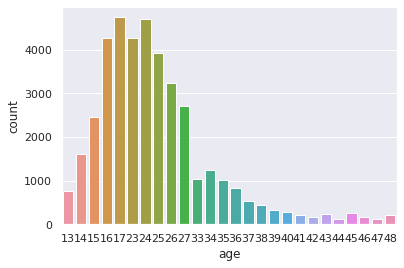

In [ ]:
sns.countplot(x="age", data=new_data);

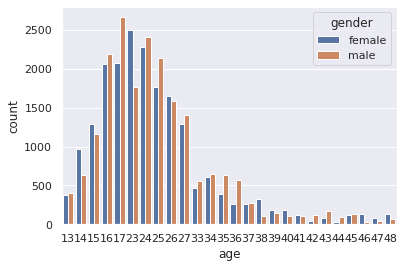

In [ ]:
sns.countplot(x="age", hue="gender", data=new_data);

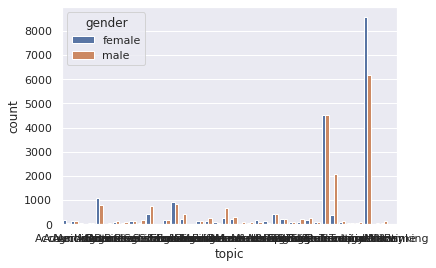

In [ ]:
sns.countplot(x="topic", hue="gender", data=new_data);

## Merge labels for multi-label classification problem

In [ ]:
new_data["age"] = new_data["age"].astype(str)
new_data["labels"] = new_data.apply(lambda col :
                            [col["gender"],col["age"],col["topic"],col["sign"]],axis =1)

In [ ]:
new_data.drop(columns=["gender","age","sign","topic"],axis =1, inplace = True)
gc.collect()

140

In [ ]:
new_data.head(10)

,index,text,labels
0,265295,cindy bkt kw masaya k n,"[female, 16, Accounting, Aquarius]"
1,299941,this start starting i neglected mind write tho...,"[female, 24, Accounting, Aquarius]"
2,608428,today quite eye opener eric jason i went eat l...,"[female, 24, Accounting, Aquarius]"
3,110820,its sunday wasnt sunday day yesterday ah well ...,"[female, 24, Accounting, Aquarius]"
4,532603,last night came home work watched tube awhile ...,"[female, 24, Accounting, Aquarius]"
5,585734,urllink pics,"[female, 24, Accounting, Aquarius]"
6,179181,the last couple days bitch half i idea brought...,"[female, 24, Accounting, Aquarius]"
7,266851,urllink me mom horse racesnbsp urllink,"[female, 24, Accounting, Aquarius]"
8,283048,holy crap really long since posted spankings l...,"[female, 24, Accounting, Aquarius]"
9,675417,urllink porchnbsp urllink,"[female, 24, Accounting, Aquarius]"


## Create Train and Test dataset

In [ ]:
from sklearn.model_selection import train_test_split

X = new_data.text
y = new_data.labels

X_train, X_test, y_train, y_test =train_test_split(X,y, random_state=42,
                                                   test_size = 0.2,
                                                  shuffle = True)

In [ ]:
print("shape of training set :", X_train.shape)
print("shape of test set :", X_test.shape)

shape of training set : (31873,)
shape of test set : (7969,)


## Vectorizing the features

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

ctv = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', 
                      ngram_range=(1, 2), stop_words = 'english')

corpus = list(X_train)+list(X_test)

In [ ]:
ctv.fit(corpus)

CountVectorizer(ngram_range=(1, 2), stop_words='english',
                token_pattern='\\w{1,}')

In [ ]:
xtrain_ctv = ctv.transform(X_train)

In [ ]:
xtest_ctv = ctv.transform(X_test)

In [ ]:
print(len(ctv.vocabulary_))

2571114


In [ ]:
ctv.get_feature_names()[:10]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['0',
 '0 0',
 '0 060',
 '0 1',
 '0 10px',
 '0 16',
 '0 175em',
 '0 1em',
 '0 1px',
 '0 2']

## Create a dictionary to get the count of every label

In [ ]:
label_counts=dict()

for labels in new_data.labels.values:
    for label in labels:
        if label in label_counts:
            label_counts[str(label)]+=1
        else:
            label_counts[str(label)]=1
        
label_counts

{'13': 769,
 '14': 1600,
 '15': 2452,
 '16': 4263,
 '17': 4742,
 '23': 4261,
 '24': 4703,
 '25': 3914,
 '26': 3234,
 '27': 2700,
 '33': 1027,
 '34': 1248,
 '35': 1018,
 '36': 827,
 '37': 541,
 '38': 438,
 '39': 322,
 '40': 292,
 '41': 215,
 '42': 165,
 '43': 245,
 '44': 115,
 '45': 260,
 '46': 158,
 '47': 129,
 '48': 204,
 'Accounting': 221,
 'Advertising': 268,
 'Agriculture': 72,
 'Aquarius': 2911,
 'Architecture': 96,
 'Aries': 3802,
 'Arts': 1899,
 'Automotive': 66,
 'Banking': 232,
 'Biotech': 127,
 'BusinessServices': 257,
 'Cancer': 3806,
 'Capricorn': 2879,
 'Chemicals': 227,
 'Communications-Media': 1181,
 'Construction': 60,
 'Consulting': 340,
 'Education': 1741,
 'Engineering': 681,
 'Environment': 32,
 'Fashion': 276,
 'Gemini': 3039,
 'Government': 395,
 'HumanResources': 178,
 'Internet': 939,
 'InvestmentBanking': 72,
 'Law': 526,
 'LawEnforcement-Security': 108,
 'Leo': 3149,
 'Libra': 3638,
 'Manufacturing': 126,
 'Maritime': 17,
 'Marketing': 275,
 'Military': 181,
 

## Transform the labels

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

# Transform between iterable of iterables and a multilabel format
binarizer=MultiLabelBinarizer(classes=sorted(label_counts.keys()))


y_train = binarizer.fit_transform(y_train)
y_test = binarizer.transform(y_test)

In [ ]:
y_train

array([[0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 1, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

### Before diving into preparing models , let's settle with Metrics to measure prediction score

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

def display_metrics_micro(Ytest, Ypred):
    print('Accuracy score: ', accuracy_score(Ytest, Ypred))
    print('F1 score: Micro', f1_score(Ytest, Ypred, average='micro'))
    print('Average precision score: Micro', average_precision_score(Ytest, Ypred, average='micro'))
    print('Average recall score: Micro', recall_score(Ytest, Ypred, average='micro'))
    
    
def display_metrics_macro(Ytest, Ypred):
    print('Accuracy score: ', accuracy_score(Ytest, Ypred))
    print('F1 score: Macro', f1_score(Ytest, Ypred, average='macro'))
    print('Average recall score: MAcro', recall_score(Ytest, Ypred, average='macro'))
    
def display_metrics_weighted(Ytest, Ypred):
    print('Accuracy score: ', accuracy_score(Ytest, Ypred))
    print('F1 score: weighted', f1_score(Ytest, Ypred, average='weighted'))
    print('Average precision score: weighted', average_precision_score(Ytest, Ypred, average='weighted'))
    print('Average recall score: weighted', recall_score(Ytest, Ypred, average='weighted'))

## OneVsRest & LogisticRegression Classiifier

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

model=LogisticRegression(C=1.0, penalty='l1', dual=False, solver='liblinear', random_state=42, class_weight= 'balanced', max_iter=100) 
model=OneVsRestClassifier(model)
model.fit(xtrain_ctv,y_train)

OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                 penalty='l1', random_state=42,
                                                 solver='liblinear'))

In [ ]:
Y_log_predicted_oneVsRest=model.predict(xtest_ctv)

## Display Metrics

In [ ]:
display_metrics_micro(y_test,Y_log_predicted_oneVsRest)

Accuracy score:  0.006776257999749027
F1 score: Micro 0.31568482017453875
Average precision score: Micro 0.1339716650305157
Average recall score: Micro 0.31377839126615636


In [ ]:
display_metrics_macro(y_test,Y_log_predicted_oneVsRest)

Accuracy score:  0.006776257999749027
F1 score: Macro 0.13654746006207458
Average recall score: MAcro 0.133816870564314


In [ ]:
display_metrics_weighted(y_test,Y_log_predicted_oneVsRest)

Accuracy score:  0.006776257999749027
F1 score: weighted 0.31392351985690436
Average precision score: weighted 0.2509637202892062
Average recall score: weighted 0.31377839126615636


### Let's check for any 10 inputs and there predicted labels

In [ ]:
import random 

def print_predicted(y_predicted, y_test = y_test , n = 10):
    j = []
    for i in range(n):
        j.append(random.randint(0, len(y_test)))
    print(j)
                 
    for k in j:
        print(binarizer.inverse_transform(y_predicted)[k])
        print(binarizer.inverse_transform(y_test)[k])
        print("------------------------------------------------------------------")

## Print true label and predicted label for any 10 examples

In [ ]:
print_predicted(y_predicted=Y_log_predicted_oneVsRest,y_test=y_test, n= 10)

[3124, 3983, 6244, 3813, 5137, 5176, 205, 3249, 2755, 7796]
('17', 'Sagittarius', 'female', 'indUnk')
('17', 'Sagittarius', 'indUnk', 'male')
------------------------------------------------------------------
('14', '15', '23', 'Arts', 'Capricorn', 'Libra', 'Student', 'Taurus', 'indUnk', 'male')
('23', 'Aries', 'Religion', 'female')
------------------------------------------------------------------
('17', '36', 'Aries', 'Fashion', 'Sagittarius', 'Sports-Recreation', 'Student', 'male')
('36', 'Aries', 'Fashion', 'male')
------------------------------------------------------------------
('female', 'indUnk')
('27', 'Cancer', 'indUnk', 'male')
------------------------------------------------------------------
('male',)
('35', 'Aquarius', 'Government', 'male')
------------------------------------------------------------------
('Aquarius', 'male')
('43', 'Libra', 'female', 'indUnk')
------------------------------------------------------------------
('35', 'Cancer', 'female')
('35', 'Pisces',

Conclusions:

1.Trained model on OnevsRest Classifer using Logistics Regression classifer. Tried to train another model, but runtime was too high therefore omitted out of final copy

2.OnevsRest with Logistic Regression gave better results in terms of test accuracy compared with LinearSVC while experimentation

3.F1-Score usually lies between Precison and Recall and hence we can compare based on either F1 score or based on Precision and Recall depending on the business need. If it is not clear, then go with F1 score as the parameter

In our case since we are dealing with an imbalanced dataset, micro - average score will be appropriate as it takes into account each instances equally rather than its counter part macro - avgerage score which considers all classes equally.

In OnevsRest with Logistic Regression micro-avg recall is higher than OnevsRest with LinerSVC tried with experimentaion.

In OnevsRest with SVC micro-avg precision is higher than OnevsRest with Logistic Regression.

If we choose F1 score then Log Regression micro-avg is higher than LinearSVC

How to improve the model scores

a. The dataset is a imbalanced multi-label classification problem, if we can have a balanced dataset, the accuracy will improve. But since data cannot be augmented with just smote and subsampling reduces the dataset to a much smaller set, therefore nothing could be done on this dataset as of now.

b. Using Statistical NLP approach limits from learning the context from the textual data which can help in better classification.

c. Due to lack of compute power we have used a small stratified random sample of the total data. If we had enough compute power running the models with the complete dataset may improve accuracy by a great deal.